<a href="https://colab.research.google.com/github/bjuhasz7054/NBD_Deep_learning/blob/main/Latent_space_analysis_background_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Hyperparameters Config


In [ ]:
RANDOM_SEED = 42
TRAIN_TEST_SPLIT_RATIO = 0.8
EPOCHS = 30
TRAIN_BATCH_SIZE = 256
VALIDATE_BATCH_SIZE = 256
DECREASE_RATIO = 1.0
PATIENCE=5
LEARNING_RATE=0.001

# Load Data

Download dataset and labels


In [ ]:
%%capture
# download dataset
!gdown --id 1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
!unzip fairface-img-margin025-trainval.zip
!rm fairface-img-margin025-trainval.zip

# download labels
!gdown --id 1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
!gdown --id 1wOdja-ezstMEp81tX1a-EYkFebev4h7D

Initialize dataframes

In [ ]:
import pandas as pd 

def split_dataset(base_dataframe, fraction):
  first = base_dataframe.sample(frac=fraction, random_state=RANDOM_SEED)
  second = base_dataframe.drop(first.index)
  return (first, second)

initial_train_dataset, _ =  split_dataset(
  base_dataframe=pd.read_csv(
    "fairface_label_train.csv"
  ),
  fraction=DECREASE_RATIO
)

validate_labels_df, _ = split_dataset(
  base_dataframe=pd.read_csv(
    "fairface_label_val.csv"
  ),
  fraction=DECREASE_RATIO
)

train_labels_df, test_labels_df = split_dataset(
  base_dataframe=initial_train_dataset,
  fraction=TRAIN_TEST_SPLIT_RATIO
)

In [ ]:
TRAIN_SIZE = len(train_labels_df)
VALIDATE_SIZE = len(validate_labels_df)
TEST_SIZE = len(test_labels_df)

dataset_size = TRAIN_SIZE + VALIDATE_SIZE + TEST_SIZE
print(f"train percantage = {TRAIN_SIZE / dataset_size * 100}%")
print(f"test percantage = {TEST_SIZE / dataset_size * 100}%")
print(f"validate percantage = {VALIDATE_SIZE / dataset_size * 100}%")

train percantage = 71.03011320600217%
test percantage = 17.757784192102193%
validate percantage = 11.212102601895637%


In [ ]:
train_labels_df

,file,age,gender,race,service_test
82770,train/82771.jpg,10-19,Male,White,False
80112,train/80113.jpg,40-49,Male,Latino_Hispanic,False
23469,train/23470.jpg,40-49,Female,Latino_Hispanic,True
37598,train/37599.jpg,40-49,Female,East Asian,True
63855,train/63856.jpg,40-49,Male,East Asian,True
...,...,...,...,...,...
1887,train/1888.jpg,50-59,Female,Latino_Hispanic,False
85721,train/85722.jpg,40-49,Male,East Asian,False
12363,train/12364.jpg,20-29,Male,East Asian,True
38531,train/38532.jpg,10-19,Male,Latino_Hispanic,False


Encode categorical data to one-hot representation

In [ ]:
class_columns=['age', 'race', 'gender']
def one_hot_encode_data(dataframe,):
  new_df=dataframe.copy()
  for coloumn in class_columns[:-1]:
    new_df[coloumn]=dataframe[coloumn].str.get_dummies().values.tolist()
  new_df['gender']=(dataframe['gender'] == 'Male').astype(int)
  return new_df

oh_train_labels_df=one_hot_encode_data(train_labels_df)
oh_validate_labels_df=one_hot_encode_data(validate_labels_df)
oh_test_labels_df=one_hot_encode_data(test_labels_df)

print(oh_train_labels_df[['age', 'race', 'gender']])

                               age                   race  gender
82770  [0, 1, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 1]       1
80112  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0]       1
23469  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0]       0
37598  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]       0
63855  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]       1
...                            ...                    ...     ...
1887   [0, 0, 0, 0, 0, 0, 1, 0, 0]  [0, 0, 0, 1, 0, 0, 0]       0
85721  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]       1
12363  [0, 0, 1, 0, 0, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]       1
38531  [0, 1, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0]       1
33590  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [1, 0, 0, 0, 0, 0, 0]       0

[69395 rows x 3 columns]


Encode categorical data to integer representation

In [ ]:
class_columns=['age', 'race', 'gender']
def int_encode_data(dataframe):
  new_df=dataframe.copy()
  for coloumn in class_columns:
    new_df[coloumn]=pd.factorize(dataframe[coloumn], sort=True)[0]
  return new_df

int_train_labels_df=int_encode_data(train_labels_df)
int_validate_labels_df=int_encode_data(validate_labels_df)
int_test_labels_df=int_encode_data(test_labels_df)

print(int_train_labels_df[['age', 'race', 'gender']])  


       age  race  gender
82770    1     6       1
80112    5     3       1
23469    5     3       0
37598    5     1       0
63855    5     1       1
...    ...   ...     ...
1887     6     3       0
85721    5     1       1
12363    2     1       1
38531    1     3       1
33590    5     0       0

[69395 rows x 3 columns]


Preprocess Image with JPEG compression

In [ ]:
import numpy as np
import imgaug.augmenters as iaa
from PIL import Image


def jpeg_compress(np_image):
  # This function can only work with this datatype
  img_list = [np_image.astype("uint8")]
  
  # 60 - 75 means, a quality of 40 - 25
  seq_free = iaa.Sequential(
    [iaa.JpegCompression(compression=(60, 75)),
     iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25))]
  )
   
  return seq_free(images=img_list)[0].astype("float32")

Create Data Generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import random 
import numpy as np


train_datagen = ImageDataGenerator(
  rotation_range=random.randint(40,90),
  width_shift_range=0.2,
  height_shift_range=0.2,
  rescale=1./255,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest',
  preprocessing_function = jpeg_compress
)

validate_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

common_generator_settings = {
  "x_col": "file",
  "y_col": ['age', 'race', 'gender'],
  "class_mode": "multi_output",
  "seed": RANDOM_SEED,
  "target_size": (224, 224),
  "validate_filenames": True
}

train_generator = train_datagen.flow_from_dataframe(
  dataframe=oh_train_labels_df,
  batch_size=TRAIN_BATCH_SIZE,
  **common_generator_settings
)

test_generator = test_datagen.flow_from_dataframe(
  dataframe=oh_test_labels_df,
  batch_size=128,
  **common_generator_settings,
  shuffle=False
)

validate_generator = validate_datagen.flow_from_dataframe(
  dataframe=oh_validate_labels_df,
  batch_size=VALIDATE_BATCH_SIZE,
  **common_generator_settings
)

Found 69395 validated image filenames.
Found 17349 validated image filenames.
Found 10954 validated image filenames.


# Create Model

In [ ]:
%%capture
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

# fix spaghetti research package
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

from keras_vggface.vggface import VGGFace

In [ ]:
# view the logs with the help of TensorBoard (Hparams tab) -> we can download the table of data
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy, Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

for layer in vgg_features.layers:
      layer.trainable = False

x = vgg_features.output

x=Dense(640, activation='leaky_relu')(x)
X=Dropout(0.2)(x)
x=Dense(896, activation='relu')(x)
X=Dropout(0.3)(x)
x=Dense(2176, activation='tanh')(x)
X=Dropout(0.4)(x)
x=Dense(640, activation='relu')(x)
X=Dropout(0.6)(x)
x=Dense(1664, activation='relu')(x)
X=Dropout(0.2)(x)

# 3 outputs, one for each category
age_output=Dense(9, activation='softmax', name='age')(x)
race_output=Dense(7, activation='softmax', name='race')(x)
gender_output=Dense(1, activation='sigmoid', name='gender')(x)


# this is the model we will train
model = Model(inputs=vgg_features.input, outputs=[age_output, race_output, gender_output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[0][0]']                
                                )                                                             

#Train Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping=EarlyStopping(patience=PATIENCE, verbose=1)
checkpointer=ModelCheckpoint(filepath='/content/drive/MyDrive/figures/final_model.hdf5', save_best_only=True, verbose=1)

Setup class weights (by category) since dataset is imbalanced

In [ ]:
from sklearn.utils import class_weight
import numpy as np
from keras.utils import np_utils
import keras.backend as K
from itertools import product

def weight_classes(dataframe_column):
  return class_weight.compute_class_weight(
    'balanced',
    classes=pd.unique(dataframe_column),
    y=dataframe_column
  )

age_class_weights_np = weight_classes(train_labels_df.age)
race_class_weights_np = weight_classes(train_labels_df.race)
gender_class_weights_np = weight_classes(train_labels_df.gender)

Custom loss function

In [ ]:
import tensorflow as tf
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = tf.dtypes.cast(y_true, tf.float64) * tf.dtypes.cast(K.log(y_pred), tf.float64) * tf.dtypes.cast(weights, tf.float64)
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
# Gender is not weighted because the relevant dataset is very close to balanced
loss_age = weighted_categorical_crossentropy(age_class_weights_np)
loss_race = weighted_categorical_crossentropy(race_class_weights_np)

Compile the model

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy, Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

model.compile(
  optimizer=Adam(learning_rate=LEARNING_RATE),
  metrics=[Accuracy(), BinaryAccuracy(), CategoricalAccuracy()],
  loss={
      'age': loss_age,
      'race': loss_race,
      'gender': BinaryCrossentropy()
  }
)

In [ ]:
from tensorflow import keras
model.load_weights("/content/drive/MyDrive/figures/final_model.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[0][0]']                
                                )                                                             

###Latent space analysis

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
# load best model
test_model = load_model("/content/drive/MyDrive/figures/final_model.hdf5", custom_objects={'loss': weighted_categorical_crossentropy})
#Age_pred, Race_pred, Gender_pred = test_model.predict(test_generator)

Selecting the convolutional layers as an encoder

In [ ]:
layers=test_model.layers[1:-8]
x=test_model.input
for layer in layers:
    x=layer(x)

trained_encoder=keras.Model(test_model.input, x)

trained_encoder.summary()

#Modified image analysis

There are 3 kinds of input images:
- Original iamges, without any modification
- Modified images, with the face not even visible
- Modified images, with segmented background

Reading in the different images

In [ ]:
from PIL import Image
import os
import numpy as np
def get_non_zero_columns(numpy_array, epsilon = 0.001):
  columns = []
  for i in range(len(numpy_array)):
    if not (numpy_array[i]<epsilon and numpy_array[i]>-epsilon):
      columns.append(i)
  return columns


def get_absolute_non_zero_colum(numpy_array, epsilon = 0.0001):
  columns = []
  for i in range(len(numpy_array)):
    if numpy_array[i]>epsilon:
      columns.append(i)
  return columns
def load_images_from_directory(directory_path):

  loaded_image_list = []
  name_list = os.listdir(directory_path)
  name_list.sort()
  print(name_list)
  for image_name in name_list:
    if image_name.endswith('jpg') or image_name.endswith('png'):
      loaded_image = np.asarray(Image.open(os.path.join(directory_path,image_name)).resize((224,224)))
      
      loaded_image = loaded_image/255.0
      print(loaded_image.shape)
      loaded_image_list.append(np.expand_dims(loaded_image, axis = 0))

  return np.vstack(loaded_image_list)

original_inputs = load_images_from_directory("/content/drive/MyDrive/Latent_Space_Analysis/Original_images_2/")

original_inputs.shape


['100.jpg', '10019.jpg', '10020.jpg', '10042.jpg', '10078.jpg', '10110.jpg']
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


(6, 224, 224, 3)

In [ ]:



original_embedding=np.empty((6,4096))

original_embedding=trained_encoder.predict(original_inputs)
original_embedding.shape

(6, 512)

In [ ]:
modified_inputs_blacked = load_images_from_directory("/content/drive/MyDrive/Latent_Space_Analysis/Modified_image_blacked/")

modified_inputs_blacked.shape

In [ ]:


modified_embedding_blacked=trained_encoder.predict(modified_inputs_blacked)


In [ ]:
modified_inputs_background = load_images_from_directory("/content/drive/MyDrive/Latent_Space_Analysis/Modified_images_background/")

modified_inputs_background.shape

['100.jpg', '10019.jpg', '10020.jpg', '10042.jpg', '10078.jpg', '10110.jpg']
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


(6, 224, 224, 3)

In [ ]:
modified_embedding_background=np.empty((6,512))

modified_embedding_background=trained_encoder.predict(modified_inputs_background)


Showing the 3 different input images

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(original_inputs[4])
plt.show()

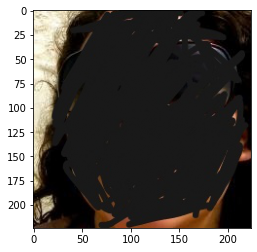

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(modified_inputs_blacked[4])
plt.show()

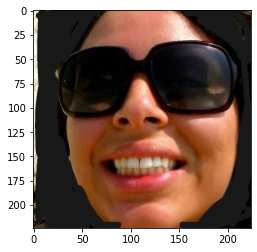

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(modified_inputs_background[4])
plt.show()

In [ ]:
for i in range(len(original_embedding)):
  print(len(get_absolute_non_zero_colum(original_embedding[i]))) #This is a simple check if the conv layers have actual non zero outputs

484
468
412
482
445
480


In [ ]:
for i in range(len(modified_embedding_blacked)):
  print(len(get_absolute_non_zero_colum(modified_embedding_blacked[i]))) #This is a simple check if the conv layers have actual non zero outputs

366
387
320
334
364
400


In [ ]:
for i in range(len(modified_embedding_background)):
  print(len(get_absolute_non_zero_colum(modified_embedding_background[i]))) #This is a simple check if the conv layers have actual non zero outputs

471
462
388
474
409
476


Predictions for the changed backgrounds:

In [ ]:
predictions = test_model.predict(np.vstack((modified_inputs_background, original_inputs)))


In [ ]:
predictions[0]
age_output = []
for i in range(len(predictions[0])):
  age_output.append(np.argmax(predictions[0][i]))

In [ ]:
age_output

[2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4]

In [ ]:
number_of_images = 6
print("Modified images - background, Original image")
for i in range(len(predictions[0])-number_of_images):
  print(predictions[0][i][age_output[i]], predictions[0][i+number_of_images][age_output[i+number_of_images]]) 


Modified images - background, Original image
0.5502591 0.58193994
0.5951768 0.5315112
0.49059153 0.44213295
0.5059679 0.3931392
0.5433812 0.4532396
0.56322575 0.59928614


In [ ]:
#Selecting the embeddings which contain useful information:
modified_embedding_background_filtered = [modified_embedding_background[1], modified_embedding_background[2], modified_embedding_background[3],modified_embedding_background[4]]

Predictions for the images without face:

In [ ]:
predictions = test_model.predict(np.vstack((modified_inputs_blacked, original_inputs)))


In [ ]:
predictions[0]
age_output = []
for i in range(len(predictions[0])):
  age_output.append(np.argmax(predictions[0][i]))

In [ ]:
age_output

[2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4]

In [ ]:
number_of_images = 6
print("Modified images - blacked, Original image")
for i in range(len(predictions[0])-number_of_images):
  if (age_output[i]!=age_output[i+number_of_images]):
    print("Change in final prediction:")
  print(predictions[0][i][age_output[i]], predictions[0][i+number_of_images][age_output[i+number_of_images]]) 


Modified images - blacked, Original image
0.31701773 0.58193994
Change in final prediction:
0.2398572 0.5315112
0.26494592 0.44213295
0.33171085 0.3931392
0.3805827 0.4532396
Change in final prediction:
0.29895654 0.59928614


#How many features are the same

Covered faces - how many features are close to the original

In [ ]:
def how_many_columns_are_same(original, modified, epsilon = 0.01):
  columns = []
  for i in range(len(original)):
    if (original[i]  > 0.000001 and modified[i]> 0.000001) or (original[i]  < -0.000001 and modified[i]  < -0.000001):
     if original[i] - epsilon < modified[i] and original[i] + epsilon > modified[i]:
        columns.append(i)
  return columns

same_columns_blacked =[]     
for i in range(len(modified_embedding_background)):
    same_columns_blacked.append(how_many_columns_are_same(original_embedding[i], modified_embedding_blacked[i]))
    print(same_columns_blacked[-1])

[0, 1, 2, 4, 6, 7, 10, 11, 12, 16, 17, 19, 20, 22, 25, 28, 29, 31, 33, 34, 38, 41, 42, 44, 49, 55, 56, 60, 61, 63, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 83, 86, 88, 90, 94, 97, 99, 102, 103, 104, 110, 114, 119, 123, 125, 129, 133, 134, 135, 136, 138, 139, 140, 143, 144, 146, 147, 151, 156, 159, 160, 162, 164, 165, 166, 169, 171, 173, 177, 178, 180, 182, 184, 186, 187, 188, 189, 192, 200, 201, 208, 210, 211, 212, 213, 218, 219, 220, 221, 226, 228, 231, 233, 234, 235, 236, 237, 240, 243, 244, 245, 247, 249, 254, 255, 256, 260, 266, 268, 272, 275, 280, 281, 286, 288, 289, 291, 292, 294, 296, 298, 300, 303, 306, 307, 308, 310, 314, 317, 318, 322, 324, 325, 328, 333, 334, 338, 340, 346, 347, 350, 354, 356, 357, 358, 360, 361, 362, 363, 364, 371, 374, 376, 377, 379, 380, 381, 383, 386, 387, 389, 390, 395, 397, 399, 400, 403, 405, 407, 408, 411, 412, 414, 415, 419, 421, 426, 428, 430, 431, 434, 437, 438, 442, 447, 450, 451, 453, 455, 459, 460, 462, 467, 468, 469, 470, 475, 477, 478, 482

Calculating the intersections of the blacked images

In [ ]:
columns_one = same_columns_blacked[0]
for i in range(len(same_columns_blacked)-1):
 
  columns_two = same_columns_blacked[i+1]


  list1_as_set = set(columns_one)
  intersection = list1_as_set.intersection(columns_two)


  intersection_as_list = list(intersection)
  print("intersection")
  print(len(intersection_as_list))

  columns_one = intersection_as_list
blacked_intersection = columns_one

intersection
131
intersection
76
intersection
55
intersection
36
intersection
22


Background embedding - how many features are the close to the original

In [ ]:
def how_many_columns_are_same(original, modified, epsilon = 0.01):
  columns = []
  for i in range(len(original)):
    if (original[i]  > 0.000001 and modified[i]> 0.000001) or (original[i]  < -0.000001 and modified[i]  < -0.000001):
     if original[i] - epsilon < modified[i] and original[i] + epsilon > modified[i]:
        columns.append(i)
  return columns

same_columns_background =[]     
for i in range(6):
    same_columns_background.append(how_many_columns_are_same(original_embedding[i], modified_embedding_background[i]))
    print(same_columns_background[-1])

[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 17, 18, 19, 20, 22, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 92, 93, 95, 96, 98, 99, 100, 101, 103, 104, 105, 107, 109, 110, 111, 113, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 141, 143, 145, 146, 147, 148, 151, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 208, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 222, 223, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 237, 239, 240, 241, 242, 243, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 

Calculating the intersections of the blacked images

In [ ]:
columns_one = same_columns_background[0]
for i in range(len(same_columns_background)-1):
 
  columns_two = same_columns_background[i+1]


  list1_as_set = set(columns_one)
  intersection = list1_as_set.difference(columns_two)


  intersection_as_list = list(intersection)
  print("intersection")
  print(len(intersection_as_list))

  columns_one = intersection_as_list

background_intersection = columns_one

intersection
102
intersection
34
intersection
13
intersection
5
intersection
3


In [ ]:
pair_intersection = list(set(same_columns_background[0]).difference(set(same_columns_blacked[0]))) #used it later during testing

In [ ]:
len(pair_intersection)

222

# Testing the new model

The model with only the dense layers

In [ ]:
dense_model = keras.Sequential()

layers=test_model.layers[21:25]


input = test_model.input
x=trained_encoder(input)
current_input = trained_encoder(input)

x = test_model.layers[20](current_input)
for layer in layers:
    x = layer(x)

age_output=test_model.layers[-3](x)
race_output=test_model.layers[-2](x)
gender_output=test_model.layers[-1](x)

dense_model = Model(inputs=current_input, outputs=[age_output, race_output, gender_output])

dense_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 640)          328320      ['input_2[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 896)          574336      ['dense_5[9][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 2176)         1951872     ['dense_6[9][0]']                
                                                                                            

In [ ]:
def custom_process(encoder_predictions, non_background_features): #If the feature's number is beleived to be a background encoding feature, then it gets a 0 weight
  attention_scalar = 1/len(non_background_features)
  new_encoder_predictions = encoder_predictions.copy()
  counter =0
  for i in range(len(encoder_predictions)):
    if i in non_background_features:
      new_encoder_predictions[i] = encoder_predictions[i]*attention_scalar
      counter +=1
    else:
      new_encoder_predictions[i] = encoder_predictions[i]*0

  
  return new_encoder_predictions

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
#First taking the outputs of the conv layers
encoder_predictions = trained_encoder.predict(test_generator)
processed_encoder_predictions = encoder_predictions.copy()





In [ ]:
for i in range(len(processed_encoder_predictions)):
  processed_encoder_predictions[i] = custom_process(processed_encoder_predictions[i], pair_intersection)
Age_pred, Race_pred, Gender_pred = dense_model.predict(processed_encoder_predictions)

In [ ]:
len(blacked_intersection)

22

In [ ]:
conv_model=Model(test_model.input, test_model.layers[-13].output)

In [ ]:
test_model.summary()

In [ ]:
#print(conv_model(x_train[0:1]/255))

In [ ]:
# convert output vectors to single integers
age_pred = np.argmax(Age_pred, axis=1)
race_pred = np.argmax(Race_pred, axis=1)
gender_pred=Gender_pred>=0.5

Confusion matrices

In [ ]:
age_labels=['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
race_labels=['Black', 'East Asian', 'Indian', 'Latino Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
gender_labels=['Female', 'Male']

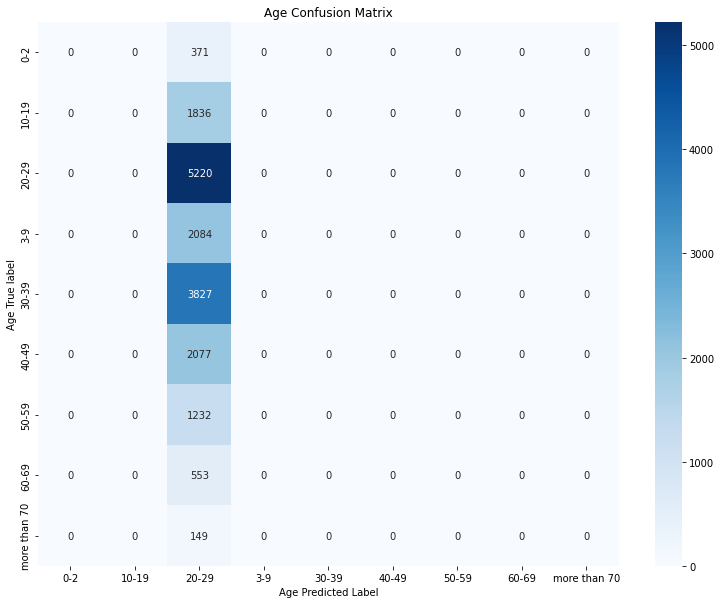

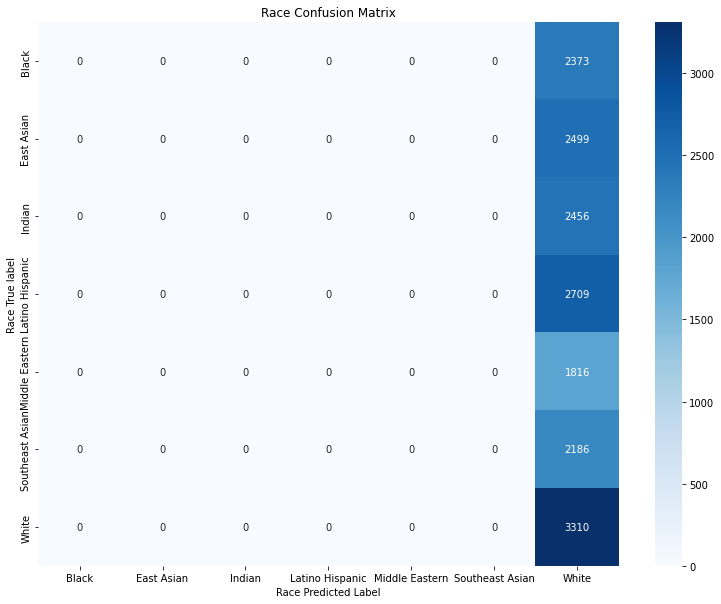

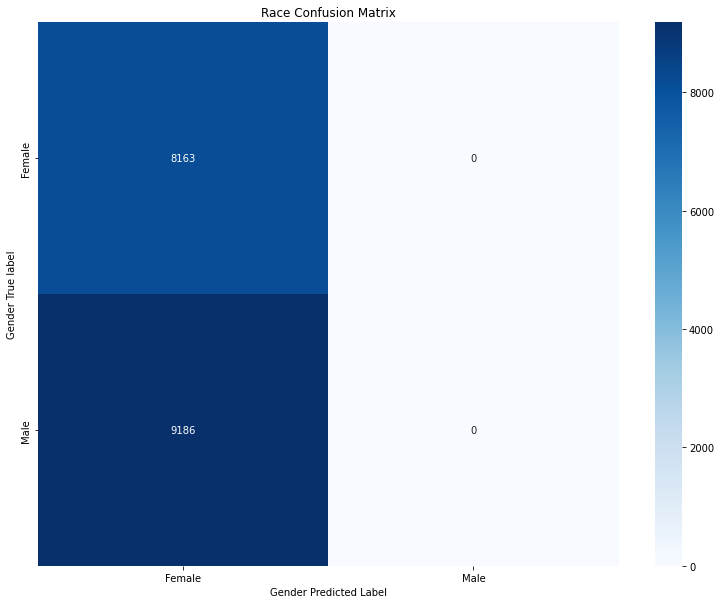

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conf = confusion_matrix(int_test_labels_df['age'].values, age_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Age Predicted Label',
       ylabel='Age True label');
ax.set_title('Age Confusion Matrix') 
ax.xaxis.set_ticklabels(age_labels)
ax.yaxis.set_ticklabels(age_labels)
plt.show()

conf = confusion_matrix(int_test_labels_df['race'].values, race_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Race Predicted Label',
       ylabel='Race True label');
ax.set_title('Race Confusion Matrix') 
ax.xaxis.set_ticklabels(race_labels)
ax.yaxis.set_ticklabels(race_labels)
plt.show()

conf = confusion_matrix(int_test_labels_df['gender'].values, gender_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Gender Predicted Label',
       ylabel='Gender True label');
ax.set_title('Race Confusion Matrix') 
ax.xaxis.set_ticklabels(gender_labels)
ax.yaxis.set_ticklabels(gender_labels)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print('Age Classification Report\n')
print(classification_report(int_test_labels_df['age'], age_pred, target_names = age_labels))

print('Race Classification Report\n')
print(classification_report(int_test_labels_df['race'], race_pred, target_names = race_labels))

print('Gender Classification Report\n')
print(classification_report(int_test_labels_df['gender'], gender_pred, target_names = gender_labels))

Age Classification Report

              precision    recall  f1-score   support

         0-2       0.56      0.72      0.63       371
       10-19       0.40      0.36      0.38      1836
       20-29       0.53      0.75      0.62      5220
         3-9       0.75      0.57      0.65      2084
       30-39       0.55      0.06      0.12      3827
       40-49       0.28      0.30      0.29      2077
       50-59       0.26      0.57      0.36      1232
       60-69       0.34      0.42      0.38       553
more than 70       0.30      0.42      0.35       149

    accuracy                           0.45     17349
   macro avg       0.44      0.46      0.42     17349
weighted avg       0.49      0.45      0.42     17349

Race Classification Report

                 precision    recall  f1-score   support

          Black       0.79      0.65      0.71      2373
     East Asian       0.72      0.49      0.58      2499
         Indian       0.51      0.65      0.57      2456
Latino Hisp

#Conclusion:
the reason for this output (predicting always the same labels) lies in the testing images. Since all of the images we modified and compared had very similar labels, the "background features" were bound to be biased. (The similarities in their feature map representations were not detected, as they were too similar.) 

###Only run this section if you want to check the results from the full model

FULL MODEL

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
# load best model
test_model = load_model("/content/drive/MyDrive/figures/final_model.hdf5", custom_objects={'loss': weighted_categorical_crossentropy})
Age_pred, Race_pred, Gender_pred = test_model.predict(test_generator)

In [ ]:
conv_model=Model(test_model.input, test_model.layers[-13].output)

In [ ]:
test_model.summary()

In [ ]:
#print(conv_model(x_train[0:1]/255))

In [ ]:
# convert output vectors to single integers
age_pred = np.argmax(Age_pred, axis=1)
race_pred = np.argmax(Race_pred, axis=1)
gender_pred=Gender_pred>=0.5

Confusion matrices

In [ ]:
age_labels=['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
race_labels=['Black', 'East Asian', 'Indian', 'Latino Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
gender_labels=['Female', 'Male']

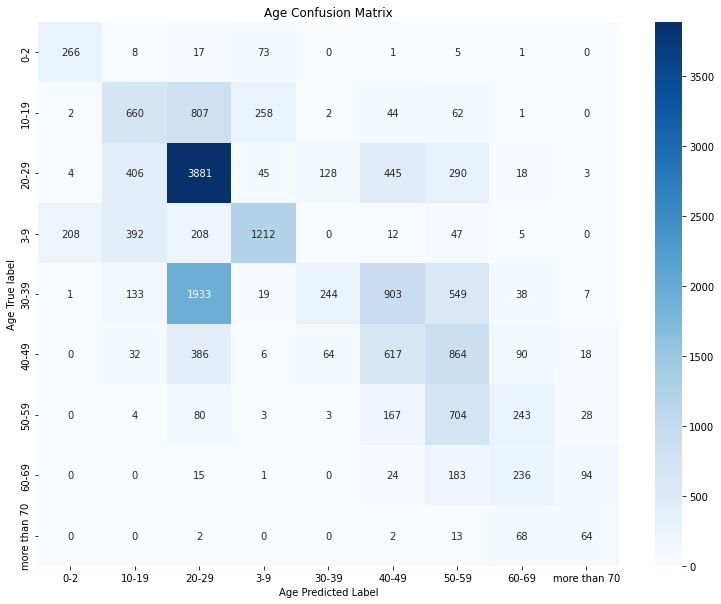

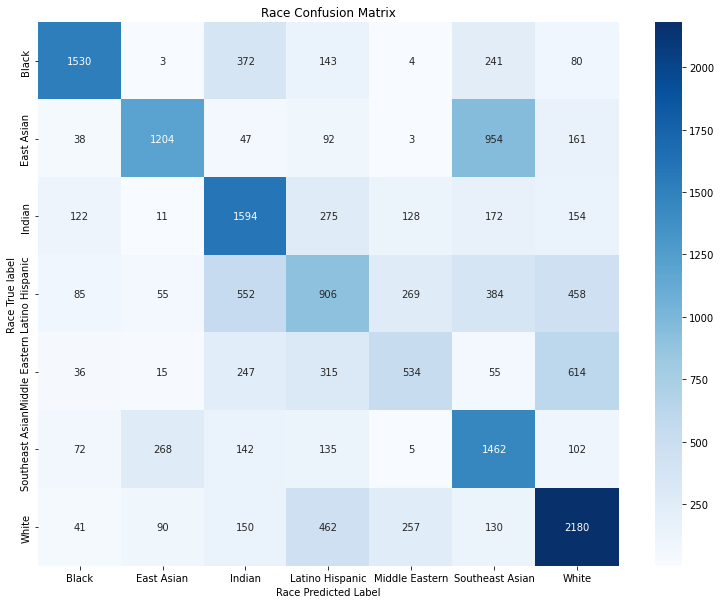

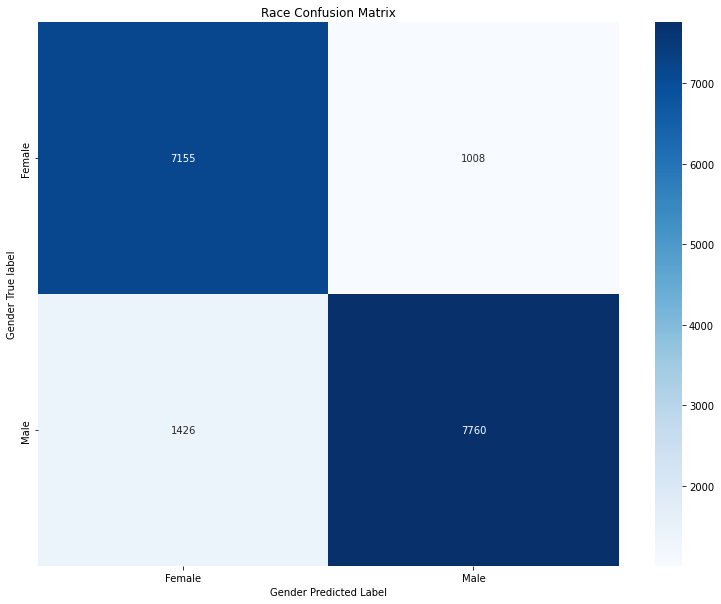

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conf = confusion_matrix(int_test_labels_df['age'].values, age_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Age Predicted Label',
       ylabel='Age True label');
ax.set_title('Age Confusion Matrix') 
ax.xaxis.set_ticklabels(age_labels)
ax.yaxis.set_ticklabels(age_labels)
plt.show()

conf = confusion_matrix(int_test_labels_df['race'].values, race_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Race Predicted Label',
       ylabel='Race True label');
ax.set_title('Race Confusion Matrix') 
ax.xaxis.set_ticklabels(race_labels)
ax.yaxis.set_ticklabels(race_labels)
plt.show()

conf = confusion_matrix(int_test_labels_df['gender'].values, gender_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Gender Predicted Label',
       ylabel='Gender True label');
ax.set_title('Race Confusion Matrix') 
ax.xaxis.set_ticklabels(gender_labels)
ax.yaxis.set_ticklabels(gender_labels)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print('Age Classification Report\n')
print(classification_report(int_test_labels_df['age'], age_pred, target_names = age_labels))

print('Race Classification Report\n')
print(classification_report(int_test_labels_df['race'], race_pred, target_names = race_labels))

print('Gender Classification Report\n')
print(classification_report(int_test_labels_df['gender'], gender_pred, target_names = gender_labels))

Age Classification Report

              precision    recall  f1-score   support

         0-2       0.55      0.72      0.62       371
       10-19       0.40      0.36      0.38      1836
       20-29       0.53      0.74      0.62      5220
         3-9       0.75      0.58      0.65      2084
       30-39       0.55      0.06      0.11      3827
       40-49       0.28      0.30      0.29      2077
       50-59       0.26      0.57      0.36      1232
       60-69       0.34      0.43      0.38       553
more than 70       0.30      0.43      0.35       149

    accuracy                           0.45     17349
   macro avg       0.44      0.47      0.42     17349
weighted avg       0.49      0.45      0.42     17349

Race Classification Report

                 precision    recall  f1-score   support

          Black       0.80      0.64      0.71      2373
     East Asian       0.73      0.48      0.58      2499
         Indian       0.51      0.65      0.57      2456
Latino Hisp

In [ ]:
import glob
import tqdm
import matplotlib
x_train=np.empty((1000, 224, 224, 3), dtype=np.uint8)
imgs=glob.glob("train/*.jpg")
img_count=0
for img in tqdm.tqdm(imgs):
   x_train[img_count]=matplotlib.image.imread(img)

   img_count+=1
   
   if(img_count==1000):
     break

In [ ]:
from sklearn import manifold
from matplotlib import offsetbox
import matplotlib
def plot_tsne(x, y, classes, with_pictures=False, name="figure.eps"):
  colors = np.asarray(plt.rcParams['axes.prop_cycle'].by_key()['color'])
  cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(0, 9+2), colors[:9+1])
  fig, ax=plt.subplots(figsize=(8,8))
  #xr=x.reshape(-1, x.shape[1]**2)
  tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
  X_tsne = tsne.fit_transform(x)
  x_min, x_max = np.min(X_tsne, 0), np.max(X_tsne, 0)
  X_tsne = (X_tsne - x_min) / (x_max - x_min)
  scatter=ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, marker='o', linewidth=1, cmap=cmap, norm=norm)

  legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                      loc="upper left", title="Osztályok", bbox_to_anchor=(1.04, 1))
  ax.add_artist(legend1)
  if (hasattr(offsetbox, 'AnnotationBbox') and with_pictures):
          # only print thumbnails with matplotlib > 1.0
          shown_images = np.array([[1., 1.]])  # just something big
          for i in range(X_tsne.shape[0]):
              dist = np.sum((X_tsne[i] - shown_images) ** 2, 1)
              if np.min(dist) < 4e-3:
                  # don't show points that are too close
                  continue
              shown_images = np.r_[shown_images, [X_tsne[i]]]
              imagebox = offsetbox.AnnotationBbox(
                  offsetbox.OffsetImage(x[i], zoom=1.5, cmap=plt.cm.gray_r),
                  X_tsne[i])
              ax.add_artist(imagebox)

  plt.savefig(name, format="pdf", bbox_inches='tight', dpi=300)
  plt.show()

In [ ]:
encoder=Model(test_model.input, test_model.layers[-4].output)

In [ ]:
plot_tsne(encoder.predict(test_generator), int_test_labels_df['age'], classes=age_labels, name='age_tsne.pdf')
plot_tsne(encoder.predict(test_generator), int_test_labels_df['race'], classes=race_labels, name='race_tsne.pdf')
plot_tsne(encoder.predict(test_generator), int_test_labels_df['gender'], classes=gender_labels, name='gender_tsne.pdf')